# Imports

In [96]:
import scipy.io as sio
import os.path as op
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pytensor.tensor as pt
from patsy import dmatrix
import pymc as pm

def softplus_np(x): return np.log1p(np.exp(-np.abs(x))) + np.maximum(x, 0)

def inverse_softplus_np(x):
    return np.log(np.exp(x) - 1.)

# Collect data

In [98]:
df= []

subjects = ['gilles', 'alina', 'sherry']

for subject in subjects:
    df.append(pd.concat([pd.read_csv(op.abspath(f'../data/{subject}_run{ix}.csv')) for ix in range(1, 5)], keys=range(1, 5), names=['run']))

df = pd.concat(df, keys=subjects, names=['subject'])
df['p'] = df['presentedProb_1'] / df['presentedProb_2']

df['p_bin'] = pd.cut(df['p'], bins=np.arange(0, 1.05, .05), labels=np.arange(0.025, 1, 0.05))
df['p_bin2'] = pd.cut(df['p'], bins=np.arange(0, 1.05, .1), labels=np.arange(0.05, 1.05, 0.1))

df['bias'] = df['certaintyEquivalent'] / 43. - df['p']


subjects = sorted(df.index.unique(level='subject'))

# Raw data plots

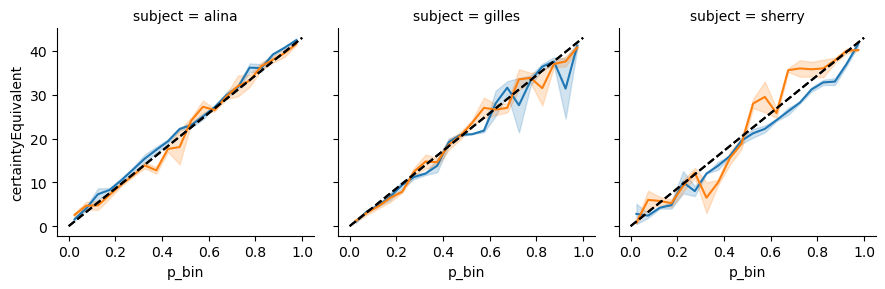

In [99]:


g = sns.FacetGrid(df.reset_index(), col='subject', hue='noiseType', col_order=subjects)
g.map_dataframe(sns.lineplot, x='p_bin', y='certaintyEquivalent', errorbar='se')

g.map(lambda *args, **kwargs: plt.plot([0, 1], [0, 43.], c='k', ls='--'))
# plt.axvline(0.5, c='k', ls='--')

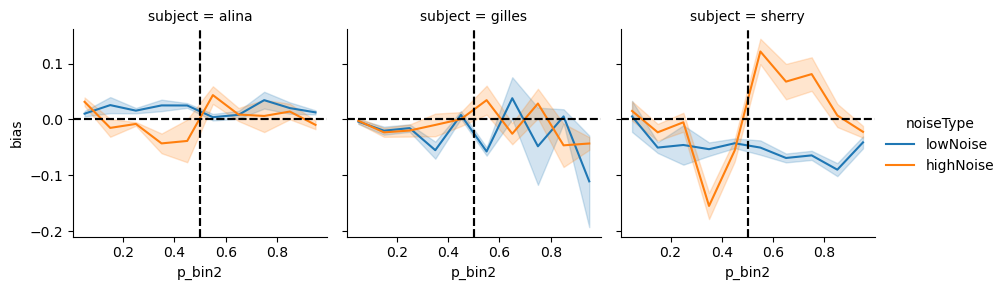

In [100]:
g = sns.FacetGrid(df.reset_index(), col='subject', hue='noiseType', col_order=subjects)
g.map_dataframe(sns.lineplot, x='p_bin2', y='bias', errorbar='se')

g.map(lambda *args, **kwargs: plt.axhline(0.0, c='k', ls='--'))
g.map(lambda *args, **kwargs: plt.axvline(0.5, c='k', ls='--'))
g.add_legend()

# Seperate models for each subject/condition

In [101]:
import pymc as pm
from patsy import dmatrix

def fit_data(data):
    dof_splines = 5

    X_p = dmatrix(f'bs(p, df={dof_splines}, degree=3, include_intercept=True) - 1', {'p':data['p']}) 


    model = pm.Model()


    with model:
        beta_p = pm.Normal('beta_p', mu=0, sigma=10., size=dof_splines)
        beta_sd = pm.Normal('beta_sd', mu=inverse_softplus_np(.1), sigma=10., size=dof_splines)

        pred_bias = pm.math.dot(X_p, beta_p)
        pred_sd = pt.softplus(pm.math.dot(X_p, beta_sd))

        ll = pm.Normal('pred', mu=pred_bias, sigma=pred_sd, observed=data['bias'].values)

        idata = pm.sample(1000, tune=1000, target_accept=0.8)


    p_to_predict = np.linspace(data['p'].min(), data['p'].max())
    X_p_ = dmatrix(f'bs(p, df={dof_splines}, degree=3, include_intercept=True) - 1', {'p':p_to_predict})

    predicted_bias = idata.posterior['beta_p'].to_dataframe().unstack('beta_p_dim_0').dot(X_p_.T)
    predicted_bias.columns = pd.Index(p_to_predict, name='p')


    predicted_bias = predicted_bias.stack().to_frame('predicted_bias')


    predicted_sd = idata.posterior['beta_sd'].to_dataframe().unstack('beta_sd_dim_0').dot(X_p_.T)
    predicted_sd.columns = pd.Index(p_to_predict, name='p')

    predicted_sd = softplus_np(predicted_sd.stack().to_frame('predicted_sd'))


    return predicted_bias.join(predicted_sd)


In [6]:
predictions = df.groupby(['subject', 'noiseType', 'probRange']).apply(fit_data)

/Users/gdehol/mambaforge/lib/python3.10/site-packages/pymc/model.py:1363: ImputationWarning: Data in pred contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_p, beta_sd, pred_unobserved]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
/Users/gdehol/mambaforge/lib/python3.10/site-packages/pymc/model.py:1363: ImputationWarning: Data in pred contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_p, beta_sd, pred_unobserved]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
/Users/gdehol/mambaforge/lib/python3.10/site-packages/pymc/model.py:1363: ImputationWarning: Data in pred contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_p, beta_sd, pred_unobserved]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_p, beta_sd]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
/Users/gdehol/mambaforge/lib/python3.10/site-packages/pymc/model.py:1363: ImputationWarning: Data in pred contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_p, beta_sd, pred_unobserved]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_p, beta_sd]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_p, beta_sd]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_p, beta_sd]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


In [7]:
# predicted_bias
import arviz as az

def get_hdi(data):
    return az.hdi(data.values)


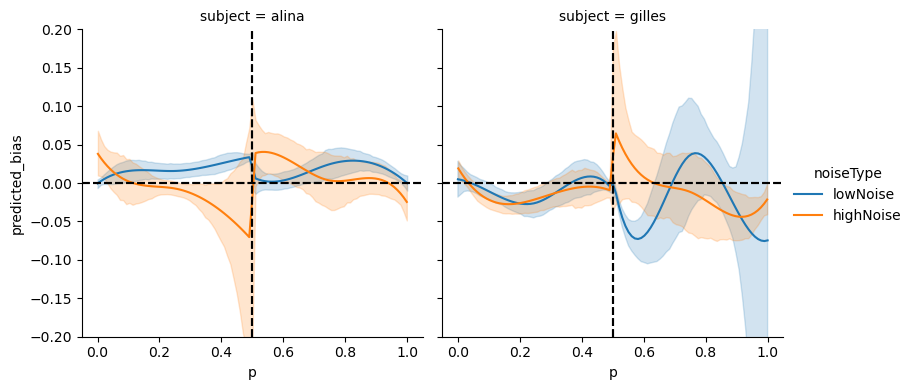

In [8]:
predictions

g = sns.FacetGrid(predictions.reset_index(), col='subject', hue='noiseType', height=4, hue_order=['lowNoise', 'highNoise'])


g.map_dataframe(sns.lineplot, x='p', y='predicted_bias', errorbar=get_hdi)

g.map(lambda *args, **kwargs: plt.axhline(0.0, c='k', ls='--'))
g.map(lambda *args, **kwargs: plt.axvline(0.5, c='k', ls='--'))

g.set(ylim=(-.2, .2))

g.add_legend()

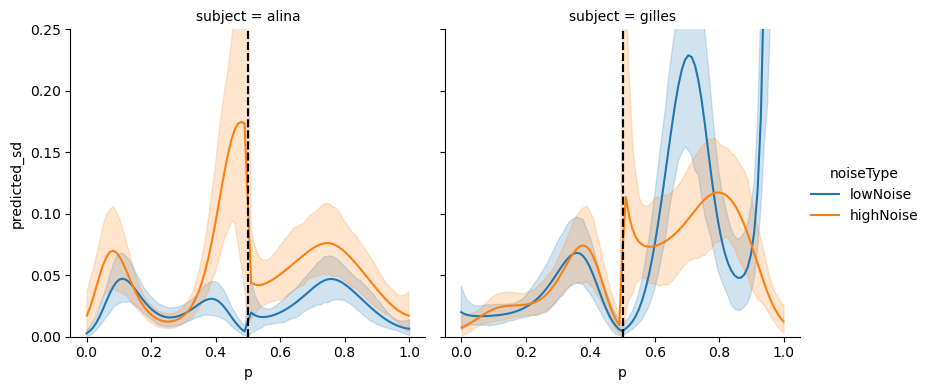

In [9]:
predictions

g = sns.FacetGrid(predictions.reset_index(), col='subject', hue='noiseType', height=4, hue_order=['lowNoise', 'highNoise'])


g.map_dataframe(sns.lineplot, x='p', y='predicted_sd', errorbar=get_hdi)

g.map(lambda *args, **kwargs: plt.axvline(0.5, c='k', ls='--'))


g.add_legend()

g.set(ylim=(0, .25))

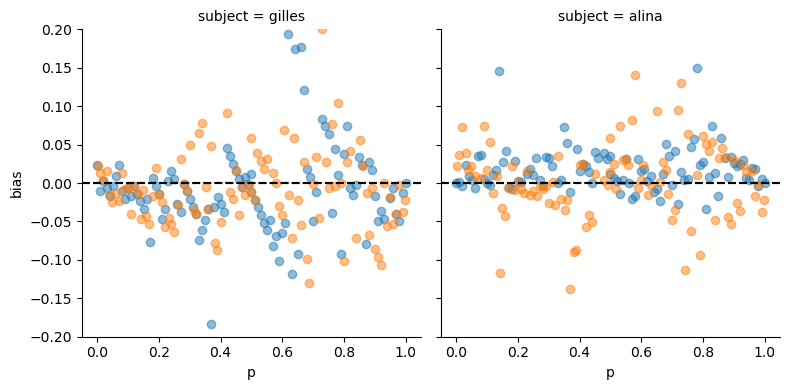

In [10]:
g = sns.FacetGrid(df.reset_index(), col='subject', hue='noiseType', height=4., col_order=df.index.unique(level='subject'))


g.map(plt.scatter, 'p', 'bias', alpha=.5)
g.set(ylim=(-.2, .2))
g.map(lambda *args, **kwargs: plt.axhline(0.0, c='k', ls='--'))


# Hierarchical model

In [121]:
data = df.copy().reset_index()

n_subjects = data['subject'].nunique()


dof_splines = 6

sub_ix, subject_mapping = pd.factorize(data['subject'])
noise_ix, noise_mapping = pd.factorize(data['noiseType'])
probrange_ix, probrange_mapping = pd.factorize(data['probRange'])

# Different design matrix for low prob and high prob range!
X_p = [dmatrix(f'bs(p, df={dof_splines}, degree=3, include_intercept=True, lower_bound=0.0, upper_bound=0.5) - 1', {'p':np.clip(data['p'], 0.0, 0.5)}),
       dmatrix(f'bs(p, df={dof_splines}, degree=3, include_intercept=True, lower_bound=.5, upper_bound=1.0) - 1', {'p':np.clip(data['p'], .5, 1.0)})]
X_p = np.array(X_p)

# Select appropriate design matrix per trial
X_p = X_p[probrange_ix, np.arange(X_p.shape[1])]

coords = {'subject': subject_mapping, 'spline_n': np.arange(dof_splines), 'noise_condition':df.noiseType.unique(), 'probRange':df.probRange.unique()}

model = pm.Model(coords=coords)

with model:

    beta_bias_mu = pm.Normal('beta_bias_mu', mu=0, sigma=.05, dims=('noise_condition', 'probRange', 'spline_n'))
    beta_bias_sd = pm.HalfCauchy('beta_bias_sd', .05, dims=('noise_condition', 'probRange', 'spline_n'))
    
    beta_sd_mu = pm.Normal('beta_sd_mu', mu=inverse_softplus_np(.1), sigma=1., dims=('noise_condition', 'probRange', 'spline_n'))
    beta_sd_sd = pm.HalfCauchy('beta_sd_sd', .05, dims=('noise_condition', 'probRange', 'spline_n'))

    subject_offset_bias = pm.Normal(f'beta_bias_offset', mu=0, sigma=1, dims=('subject', 'noise_condition', 'probRange', 'spline_n'))
    subject_offset_sd = pm.Normal(f'beta_d_offset', mu=0, sigma=1, dims=('subject', 'noise_condition', 'probRange', 'spline_n'))

    beta_bias = pm.Deterministic('beta_bias', beta_bias_mu + subject_offset_bias * beta_bias_sd, dims=('subject', 'noise_condition', 'probRange', 'spline_n'))
    beta_sd = pm.Deterministic('beta_sd', beta_sd_mu + subject_offset_sd * beta_sd_sd, dims=('subject', 'noise_condition', 'probRange', 'spline_n'))


    print(beta_bias[sub_ix, noise_ix, probrange_ix, :].shape.eval())

    print(X_p.shape)

    # pred_bias = pm.math.dot(X_p, beta_bias[sub_ix, noise_ix, probrange_ix, :])
    pred_bias = pt.sum(X_p * beta_bias[sub_ix, noise_ix, probrange_ix, :], axis=1)
    pred_sd = pt.softplus(pt.sum(X_p * beta_sd[sub_ix, noise_ix, probrange_ix, :], axis=1))

    print(pred_bias.shape.eval())

    ll = pm.Normal('pred', mu=pred_bias, sigma=pred_sd, observed=data['bias'].values)

    idata = pm.sample(1500, tune=1500, target_accept=0.9)

[612   6]
(612, 6)
[612]


/Users/gdehol/mambaforge/lib/python3.10/site-packages/pymc/model.py:1363: ImputationWarning: Data in pred contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_bias_mu, beta_bias_sd, beta_sd_mu, beta_sd_sd, beta_bias_offset, beta_d_offset, pred_unobserved]


Sampling 4 chains for 1_500 tune and 1_500 draw iterations (6_000 + 6_000 draws total) took 435 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 214 divergences after tuning. Increase `target_accept` or reparameterize.


In [122]:

sub_ix, subject_mapping = pd.factorize(data['subject'])
noise_ix, noise_mapping = pd.factorize(data['noiseType'])
probrange_ix, probrange_mapping = pd.factorize(data['probRange'])

In [123]:
p_low = np.linspace(0, .5, 100) 
X_p_low = dmatrix(f'bs(p, df={dof_splines}, degree=3, include_intercept=True, lower_bound=0.0, upper_bound=0.5) - 1', {'p':p_low})

p_high = np.linspace(.5, 1.0, 100)
X_p_high = dmatrix(f'bs(p, df={dof_splines}, degree=3, include_intercept=True, lower_bound=.5, upper_bound=1.0) - 1', {'p':p_high})

In [124]:
beta_bias = idata.posterior['beta_bias'].to_dataframe().unstack('spline_n')


bias_lower = pd.DataFrame((beta_bias.xs('00to050', 0, 'probRange').values[:, :, np.newaxis] * np.asarray(X_p_low).T[np.newaxis, :, :]).sum(1), index=beta_bias.xs('00to050', 0, 'probRange').index, columns=pd.Index(p_low, name='p'))
bias_higher = pd.DataFrame((beta_bias.xs('50to100', 0, 'probRange').values[:, :, np.newaxis] * np.asarray(X_p_high).T[np.newaxis, :, :]).sum(1), index=beta_bias.xs('50to100', 0, 'probRange').index, columns=pd.Index(p_high, name='p'))

estimated_bias = pd.concat([bias_lower.stack(), bias_higher.stack()], axis=0, keys=['00to050', '50to100'], names=['probRange']).to_frame('estimated_bias')

In [125]:
# predicted_bias
import arviz as az

def get_hdi(data):
    return az.hdi(data.values, .67)


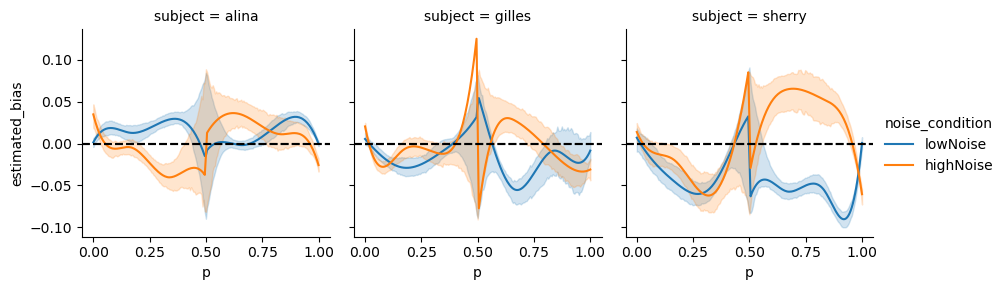

In [126]:
g = sns.FacetGrid(estimated_bias.reset_index(), col='subject', hue='noise_condition', hue_order=['lowNoise', 'highNoise'], col_order=subjects)

g.map(sns.lineplot, 'p', 'estimated_bias', errorbar=get_hdi)
g.map(lambda *args, **kwargs: plt.axhline(0.0, c='k', ls='--'))
g.add_legend()

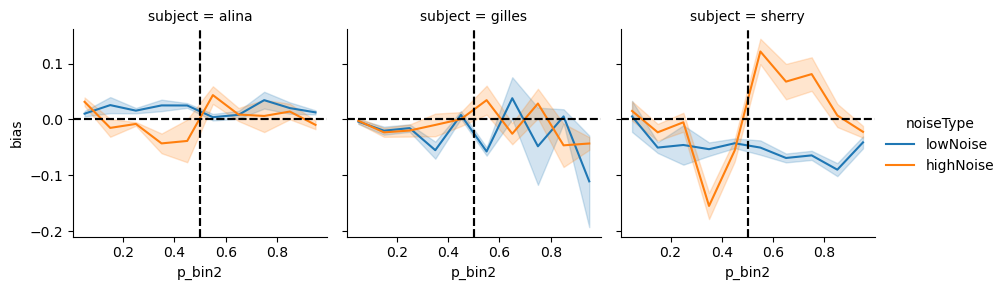

In [127]:
g = sns.FacetGrid(df.reset_index(), col='subject', hue='noiseType', col_order=subjects)
g.map_dataframe(sns.lineplot, x='p_bin2', y='bias', errorbar='se')

g.map(lambda *args, **kwargs: plt.axhline(0.0, c='k', ls='--'))
g.map(lambda *args, **kwargs: plt.axvline(0.5, c='k', ls='--'))
g.add_legend()

In [128]:
beta_sd = idata.posterior['beta_sd'].to_dataframe().unstack('spline_n')


sd_lower = pd.DataFrame(softplus_np((beta_sd.xs('00to050', 0, 'probRange').values[:, :, np.newaxis] * np.asarray(X_p_low).T[np.newaxis, :, :]).sum(1)), index=beta_sd.xs('00to050', 0, 'probRange').index, columns=pd.Index(p_low, name='p'))
sd_higher = pd.DataFrame(softplus_np((beta_sd.xs('50to100', 0, 'probRange').values[:, :, np.newaxis] * np.asarray(X_p_high).T[np.newaxis, :, :]).sum(1)), index=beta_sd.xs('50to100', 0, 'probRange').index, columns=pd.Index(p_high, name='p'))

estimated_sd = pd.concat([sd_lower.stack(), sd_higher.stack()], axis=0, keys=['00to050', '50to100'], names=['probRange']).to_frame('estimated_sd')

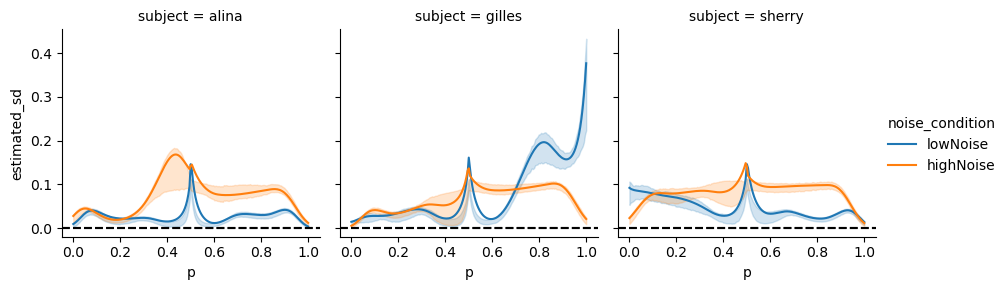

In [129]:
g = sns.FacetGrid(estimated_sd.reset_index(), col='subject', hue='noise_condition', hue_order=['lowNoise', 'highNoise'], col_order=subjects)

g.map(sns.lineplot, 'p', 'estimated_sd', errorbar=get_hdi)
g.map(lambda *args, **kwargs: plt.axhline(0.0, c='k', ls='--'))
g.add_legend()

# group level

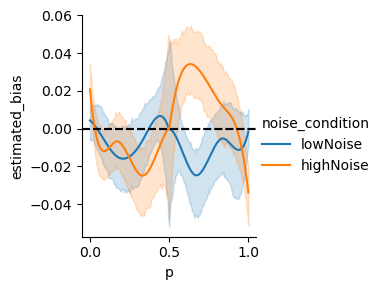

In [130]:
beta_bias = idata.posterior['beta_bias_mu'].to_dataframe().unstack('spline_n')


bias_lower = pd.DataFrame((beta_bias.xs('00to050', 0, 'probRange').values[:, :, np.newaxis] * np.asarray(X_p_low).T[np.newaxis, :, :]).sum(1), index=beta_bias.xs('00to050', 0, 'probRange').index, columns=pd.Index(p_low, name='p'))
bias_higher = pd.DataFrame((beta_bias.xs('50to100', 0, 'probRange').values[:, :, np.newaxis] * np.asarray(X_p_high).T[np.newaxis, :, :]).sum(1), index=beta_bias.xs('50to100', 0, 'probRange').index, columns=pd.Index(p_high, name='p'))

estimated_bias = pd.concat([bias_lower.stack(), bias_higher.stack()], axis=0, keys=['00to050', '50to100'], names=['probRange']).to_frame('estimated_bias')


g = sns.FacetGrid(estimated_bias.reset_index(), hue='noise_condition', hue_order=['lowNoise', 'highNoise'])

g.map(sns.lineplot, 'p', 'estimated_bias', errorbar=get_hdi)
g.map(lambda *args, **kwargs: plt.axhline(0.0, c='k', ls='--'))
g.add_legend()

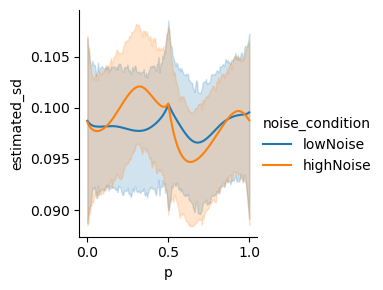

In [131]:
beta_sd = idata.posterior['beta_sd_mu'].to_dataframe().unstack('spline_n')


sd_lower = pd.DataFrame(softplus_np((beta_sd.xs('00to050', 0, 'probRange').values[:, :, np.newaxis] * np.asarray(X_p_low).T[np.newaxis, :, :]).sum(1)), index=beta_sd.xs('00to050', 0, 'probRange').index, columns=pd.Index(p_low, name='p'))
sd_higher = pd.DataFrame(softplus_np((beta_sd.xs('50to100', 0, 'probRange').values[:, :, np.newaxis] * np.asarray(X_p_high).T[np.newaxis, :, :]).sum(1)), index=beta_sd.xs('50to100', 0, 'probRange').index, columns=pd.Index(p_high, name='p'))

estimated_sd = pd.concat([sd_lower.stack(), sd_higher.stack()], axis=0, keys=['00to050', '50to100'], names=['probRange']).to_frame('estimated_sd')

g = sns.FacetGrid(estimated_sd.reset_index(), hue='noise_condition', hue_order=['lowNoise', 'highNoise'])

g.map(sns.lineplot, 'p', 'estimated_sd', errorbar=get_hdi)
# g.map(lambda *args, **kwargs: plt.axhline(0.0, c='k', ls='--'))
g.add_legend()

# PPC

In [132]:
with model:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

/Users/gdehol/mambaforge/lib/python3.10/site-packages/pymc/pytensorf.py:1055: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x2B42F67A0>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [pred_observed]


In [133]:
data.index

RangeIndex(start=0, stop=612, step=1)

In [134]:
pred = idata.posterior_predictive['pred'].to_dataframe().unstack()
pred.columns = df.index
pred = pred.T.stack([0, 1]).to_frame('predicted_bias')
pred = pred.join(df[['p', 'bias', 'noiseType', 'probRange']])

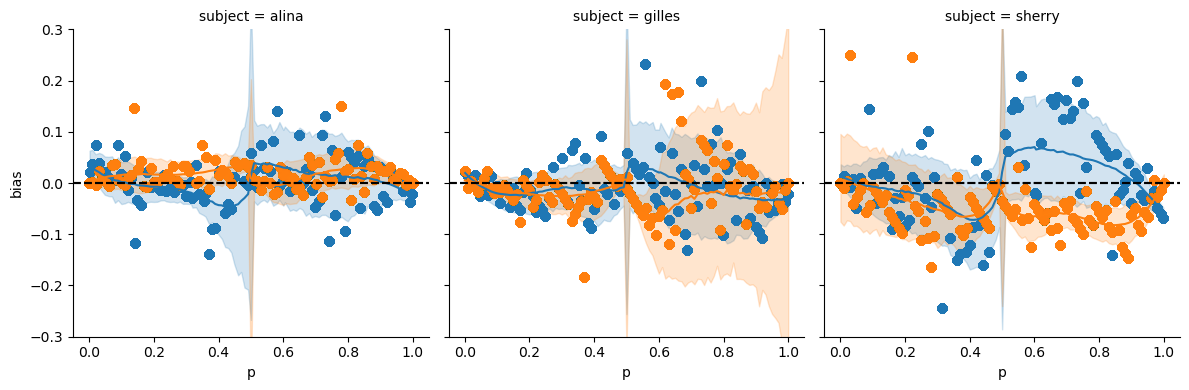

In [135]:
g = sns.FacetGrid(pred.reset_index(), col='subject', hue='noiseType', col_order=subjects, height=4)

g.map(sns.lineplot, 'p', 'predicted_bias', errorbar=get_hdi)
g.map(plt.scatter, 'p', 'bias', alpha=.5)
g.map(lambda *args, **kwargs: plt.axhline(0.0, c='k', ls='--'))

g.set(ylim=(-.3, .3))

In [136]:
mean_pred = pred.groupby(['subject', 'noiseType', 'probRange', 'p'])[['predicted_bias']].mean()
ci_pred = pred.groupby(['subject', 'noiseType', 'probRange', 'p'])['predicted_bias'].apply(lambda d: pd.Series(get_hdi(d), index=['ci025', 'ci975'])).unstack()

data_stats = df.groupby(['subject', 'noiseType', 'probRange', 'p'])[['bias']].mean()
pred_stats = mean_pred.join(ci_pred).join(data_stats)

In [137]:
def plot_ci(data, **kwargs):
    plt.fill_between(data['p'], data['ci025'], data['ci975'], alpha=.5, **kwargs)

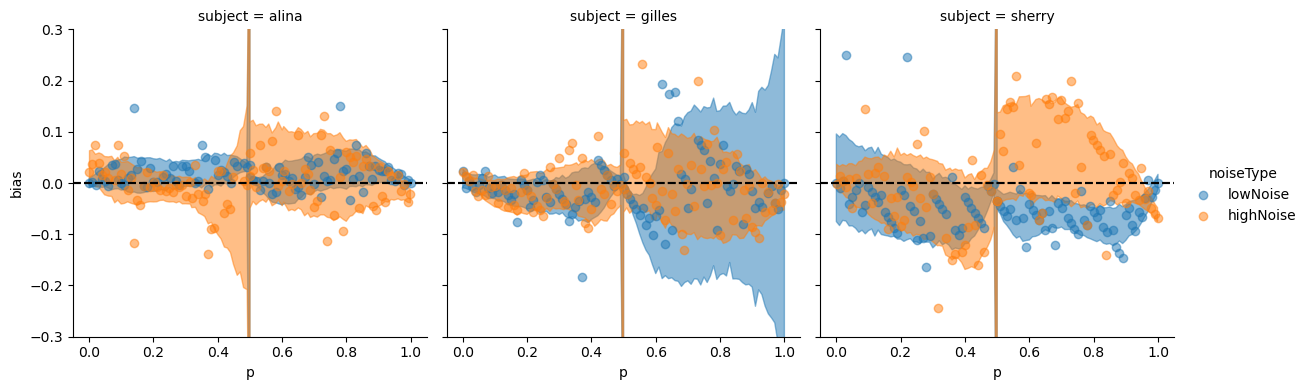

In [138]:
g = sns.FacetGrid(pred_stats.reset_index(), col='subject', hue='noiseType', col_order=subjects, height=4, hue_order=['lowNoise', 'highNoise'])

g.map_dataframe(plot_ci)
g.map(plt.scatter, 'p', 'bias', alpha=.5)
g.map(lambda *args, **kwargs: plt.axhline(0.0, c='k', ls='--'))
g.set(ylim=(-.3, .3))
g.add_legend()